# Task 1: Training a 3-layer CNN to be fooled

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
from pathlib import Path

# setting up training device? checking if GPU is available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using CPU


### CNN Architecture (2 conv + 4 FC)


In [2]:
# 2 conv layers + 4 fully-connected layers
# NOTE: ReLUs are NOT in-place because Grad-CAM uses backward hooks,
# and in-place ops can break autograd when hooks are present.

conv1_features = 6
conv2_features = 12


class TwoConvFourFC(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, conv1_features, kernel_size=9, padding="same")
        self.relu1 = nn.ReLU(inplace=False)
        self.pool1 = nn.MaxPool2d(2)  # 28 -> 14

        self.conv2 = nn.Conv2d(conv1_features, conv2_features, kernel_size=7, padding="same")
        self.relu2 = nn.ReLU(inplace=False)
        self.pool2 = nn.MaxPool2d(2)  # 14 -> 7

        flat_dim = conv2_features * 7 * 7

        self.fc1 = nn.Linear(flat_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # self.fc4 = nn.Linear(128, 10)

        self.relu_fc = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)

        x = self.relu_fc(self.fc1(x))
        x = self.relu_fc(self.fc2(x))
        x = self.fc3(x)
        # x = self.fc4(x)
        return x


model = TwoConvFourFC()


### Sanity check: standard MNIST (to verify the CNN/training loop works)

This section trains the same `TwoConvFourFC` on real MNIST first.
MNIST is grayscale (1×28×28), so we replicate it to 3 channels to match the model input (3×28×28).

In [3]:
# --- Load standard MNIST and adapt to 3-channel input ---
MNIST_ROOT = Path("../data/torchvision")

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1ch -> 3ch
])

mnist_train_dataset = datasets.MNIST(
    root=MNIST_ROOT,
    train=True,
    download=True,
    transform=mnist_transform,
)
mnist_test_dataset = datasets.MNIST(
    root=MNIST_ROOT,
    train=False,
    download=True,
    transform=mnist_transform,
)

mnist_train_loader = DataLoader(
    mnist_train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
mnist_test_loader = DataLoader(
    mnist_test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f"MNIST train samples: {len(mnist_train_dataset)}")
print(f"MNIST test samples:  {len(mnist_test_dataset)}")


MNIST train samples: 60000
MNIST test samples:  10000


In [4]:
# --- Train the same architecture on standard MNIST (same setup as Colored-MNIST training) ---
mnist_model = TwoConvFourFC().to(device)

mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.SGD(
    mnist_model.parameters(),
    lr=0.005,
    momentum=0.9,
    # weight_decay=1e-4,
)
mnist_scheduler = optim.lr_scheduler.MultiStepLR(
    mnist_optimizer,
    milestones=[9, 18, 24],
    gamma=0.1,
)


def mnist_evaluate(loader, name: str) -> float:
    mnist_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = mnist_model(images)
            preds = logits.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    acc = 100.0 * correct / max(total, 1)
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc


mnist_epochs = 7
print(f"Training TwoConvFourFC on MNIST for {mnist_epochs} epochs...")

for epoch in range(mnist_epochs):
    mnist_model.train()
    running_loss = 0.0

    for images, labels in mnist_train_loader:
        images, labels = images.to(device), labels.to(device)
        mnist_optimizer.zero_grad()
        logits = mnist_model(images)
        loss = mnist_criterion(logits, labels)
        loss.backward()
        mnist_optimizer.step()
        running_loss += loss.item()

    mnist_scheduler.step()
    current_lr = mnist_optimizer.param_groups[0]["lr"]

    print(
        f"Epoch [{epoch+1}/{mnist_epochs}] - Loss: {running_loss/len(mnist_train_loader):.4f} | lr={current_lr:.5f}"
    )
    mnist_evaluate(mnist_train_loader, "MNIST Train")
    mnist_evaluate(mnist_test_loader, "MNIST Test")
    print("-" * 30)

print("MNIST sanity check complete.")


Training TwoConvFourFC on MNIST for 7 epochs...


/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch [1/7] - Loss: 2.2949 | lr=0.00500
MNIST Train Accuracy: 29.40%
MNIST Test Accuracy: 29.43%
------------------------------
Epoch [2/7] - Loss: 1.4642 | lr=0.00500
MNIST Train Accuracy: 82.40%
MNIST Test Accuracy: 83.24%
------------------------------
Epoch [3/7] - Loss: 0.3804 | lr=0.00500
MNIST Train Accuracy: 89.38%
MNIST Test Accuracy: 90.06%
------------------------------
Epoch [4/7] - Loss: 0.2479 | lr=0.00500
MNIST Train Accuracy: 93.48%
MNIST Test Accuracy: 93.98%
------------------------------
Epoch [5/7] - Loss: 0.1869 | lr=0.00500
MNIST Train Accuracy: 94.99%
MNIST Test Accuracy: 95.52%
------------------------------
Epoch [6/7] - Loss: 0.1525 | lr=0.00500
MNIST Train Accuracy: 96.09%
MNIST Test Accuracy: 96.54%
------------------------------
Epoch [7/7] - Loss: 0.1259 | lr=0.00500
MNIST Train Accuracy: 96.29%
MNIST Test Accuracy: 96.60%
------------------------------
MNIST sanity check complete.


### Load and Pre-process data

In [5]:
BASE_TRANSFORM = transforms.ToTensor() # HWC -> CWH, scaling from 0-255 to 0-1

DATA_ROOT = Path("../task0/outputs/colored-mnist")

# loads up csv into pandas data frame
def load_meta(split: str) -> pd.DataFrame:
    path = DATA_ROOT / split / "labels.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found. Run generation first.")
    return pd.read_csv(path)

# loads image from disk, with normalization cuz it calls BASE_TRANSFORM
def _load_rgb(split: str, filename: str) -> torch.Tensor:
    path = DATA_ROOT / split / "images" / filename
    return BASE_TRANSFORM(Image.open(path).convert("RGB"))


class ColoredMNISTDataset(Dataset):
    def __init__(self, split: str, subset_indices=None):
        assert split in {"train", "test"}
        self.split = split
        self.meta = load_meta(split) # pd data frame for this split

        if subset_indices is not None:
            self.meta = self.meta.iloc[subset_indices].reset_index(drop=True)
        # talking only a subset of the data for train/val split, and ensuring 0 indexing of this subset

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img = _load_rgb(self.split, row.filename)  # (3, 28, 28)
        label = int(row.label)
        return img, label # label is the digit inside the image!


# Use the full provided train/test splits (no train/val split)
train_dataset = ColoredMNISTDataset("train")
test_dataset = ColoredMNISTDataset("test")

train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 60000
Test samples: 10000


In [6]:
# --- Bias diagnostics: how strong is the color shortcut? ---

def _bias_report(df: pd.DataFrame, split_name: str):
    if "color_digit" not in df.columns:
        print(f"[{split_name}] No 'color_digit' column found in labels.csv")
        return

    y = df["label"].to_numpy()
    c = df["color_digit"].to_numpy()

    same = (y == c)
    color_only_acc = same.mean() * 100.0

    # per-class correlation (helpful to spot bugs in generation)
    per_digit = {}
    for d in range(10):
        mask = (y == d)
        if mask.any():
            per_digit[d] = float((c[mask] == d).mean() * 100.0)

    print(f"[{split_name}] % (label == color_digit): {color_only_acc:.2f}%")
    print(f"[{split_name}] per-digit % color matches label:")
    print(per_digit)


train_meta = load_meta("train")
test_meta = load_meta("test")

_bias_report(train_meta, "TRAIN")
_bias_report(test_meta, "TEST")

print("\nInterpretation:")
print("- TRAIN near ~95% means a strong shortcut exists.")
print("- TEST near ~0% means hard test is fully inverted (no dominant colors).")
print("- A 'color-only baseline' would score exactly these percentages.")


[TRAIN] % (label == color_digit): 95.02%
[TRAIN] per-digit % color matches label:
{0: 95.52591592098598, 1: 95.2091367546722, 2: 94.91440080563947, 3: 94.56858587506116, 4: 94.91612461485792, 5: 94.87179487179486, 6: 95.31936465021967, 7: 94.8124501197127, 8: 94.70176038284053, 9: 95.29332660951421}
[TEST] % (label == color_digit): 0.00%
[TEST] per-digit % color matches label:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}

Interpretation:
- TRAIN near ~95% means a strong shortcut exists.
- TEST near ~0% means hard test is fully inverted (no dominant colors).
- A 'color-only baseline' would score exactly these percentages.


In [7]:
# --- Grad-CAM utilities (visualize what the CNN focuses on) ---
import torch.nn.functional as F
import numpy as np

class GradCAM:
    """Minimal Grad-CAM for a single target layer (e.g., the last conv layer)."""

    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self._handles = []
        self._handles.append(self.target_layer.register_forward_hook(self._forward_hook))
        # full backward hook is the most reliable in modern PyTorch
        self._handles.append(self.target_layer.register_full_backward_hook(self._backward_hook))

    def _forward_hook(self, module, inputs, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        for h in self._handles:
            h.remove()
        self._handles = []

    def __call__(self, x: torch.Tensor, class_idx: torch.Tensor | None = None):
        """Return normalized CAMs in [0,1] of shape (N,1,H,W) and logits."""
        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)

        scores = logits.gather(1, class_idx.view(-1, 1)).squeeze(1)
        self.model.zero_grad(set_to_none=True)
        scores.sum().backward()

        grads = self.gradients
        acts = self.activations
        if grads is None or acts is None:
            raise RuntimeError("Grad-CAM hooks did not capture gradients/activations. Check target_layer.")

        # global-average-pool gradients -> weights
        weights = grads.mean(dim=(2, 3), keepdim=True)  # (N,C,1,1)
        cam = (weights * acts).sum(dim=1, keepdim=True)  # (N,1,H,W)
        cam = F.relu(cam)

        # normalize per-image to [0,1]
        cam_flat = cam.flatten(1)
        cam_min = cam_flat.min(dim=1)[0].view(-1, 1, 1, 1)
        cam_max = cam_flat.max(dim=1)[0].view(-1, 1, 1, 1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        return cam.detach(), logits.detach()


def show_gradcam_overlays(
    images: torch.Tensor,
    cam_pred: torch.Tensor,
    cam_true: torch.Tensor | None,
    labels: torch.Tensor,
    preds: torch.Tensor,
    *,
    epoch: int,
    max_items: int = 6,
):
    """Plot original + Grad-CAM overlay(s) for a few samples."""
    n = int(min(max_items, images.size(0)))

    # upsample CAM to input resolution
    cam_pred_up = F.interpolate(cam_pred[:n], size=images.shape[-2:], mode="bilinear", align_corners=False)
    cam_true_up = None
    if cam_true is not None:
        cam_true_up = F.interpolate(cam_true[:n], size=images.shape[-2:], mode="bilinear", align_corners=False)

    imgs = images[:n].detach().cpu()
    cam_pred_up = cam_pred_up.detach().cpu().squeeze(1)
    if cam_true_up is not None:
        cam_true_up = cam_true_up.detach().cpu().squeeze(1)
    labels = labels[:n].detach().cpu()
    preds = preds[:n].detach().cpu()

    cols = 3 if cam_true_up is not None else 2
    fig, axes = plt.subplots(n, cols, figsize=(4.5 * cols, 3.2 * n))
    if n == 1:
        axes = np.array([axes])

    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Epoch {epoch} | y={labels[i].item()} pred={preds[i].item()}")
        axes[i, 0].axis("off")

        heat_pred = cam_pred_up[i].numpy()
        axes[i, 1].imshow(img)
        axes[i, 1].imshow(heat_pred, cmap="jet", alpha=0.45, vmin=0.0, vmax=1.0)
        axes[i, 1].set_title("Grad-CAM (pred class)")
        axes[i, 1].axis("off")

        if cam_true_up is not None:
            heat_true = cam_true_up[i].numpy()
            axes[i, 2].imshow(img)
            axes[i, 2].imshow(heat_true, cmap="jet", alpha=0.45, vmin=0.0, vmax=1.0)
            axes[i, 2].set_title("Grad-CAM (true class)")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


### Training

Training for 6 epochs...
Epoch [1/6] - Loss: 2.2078 | lr=0.00500
Train Accuracy: 36.67%
Test Accuracy: 7.24%


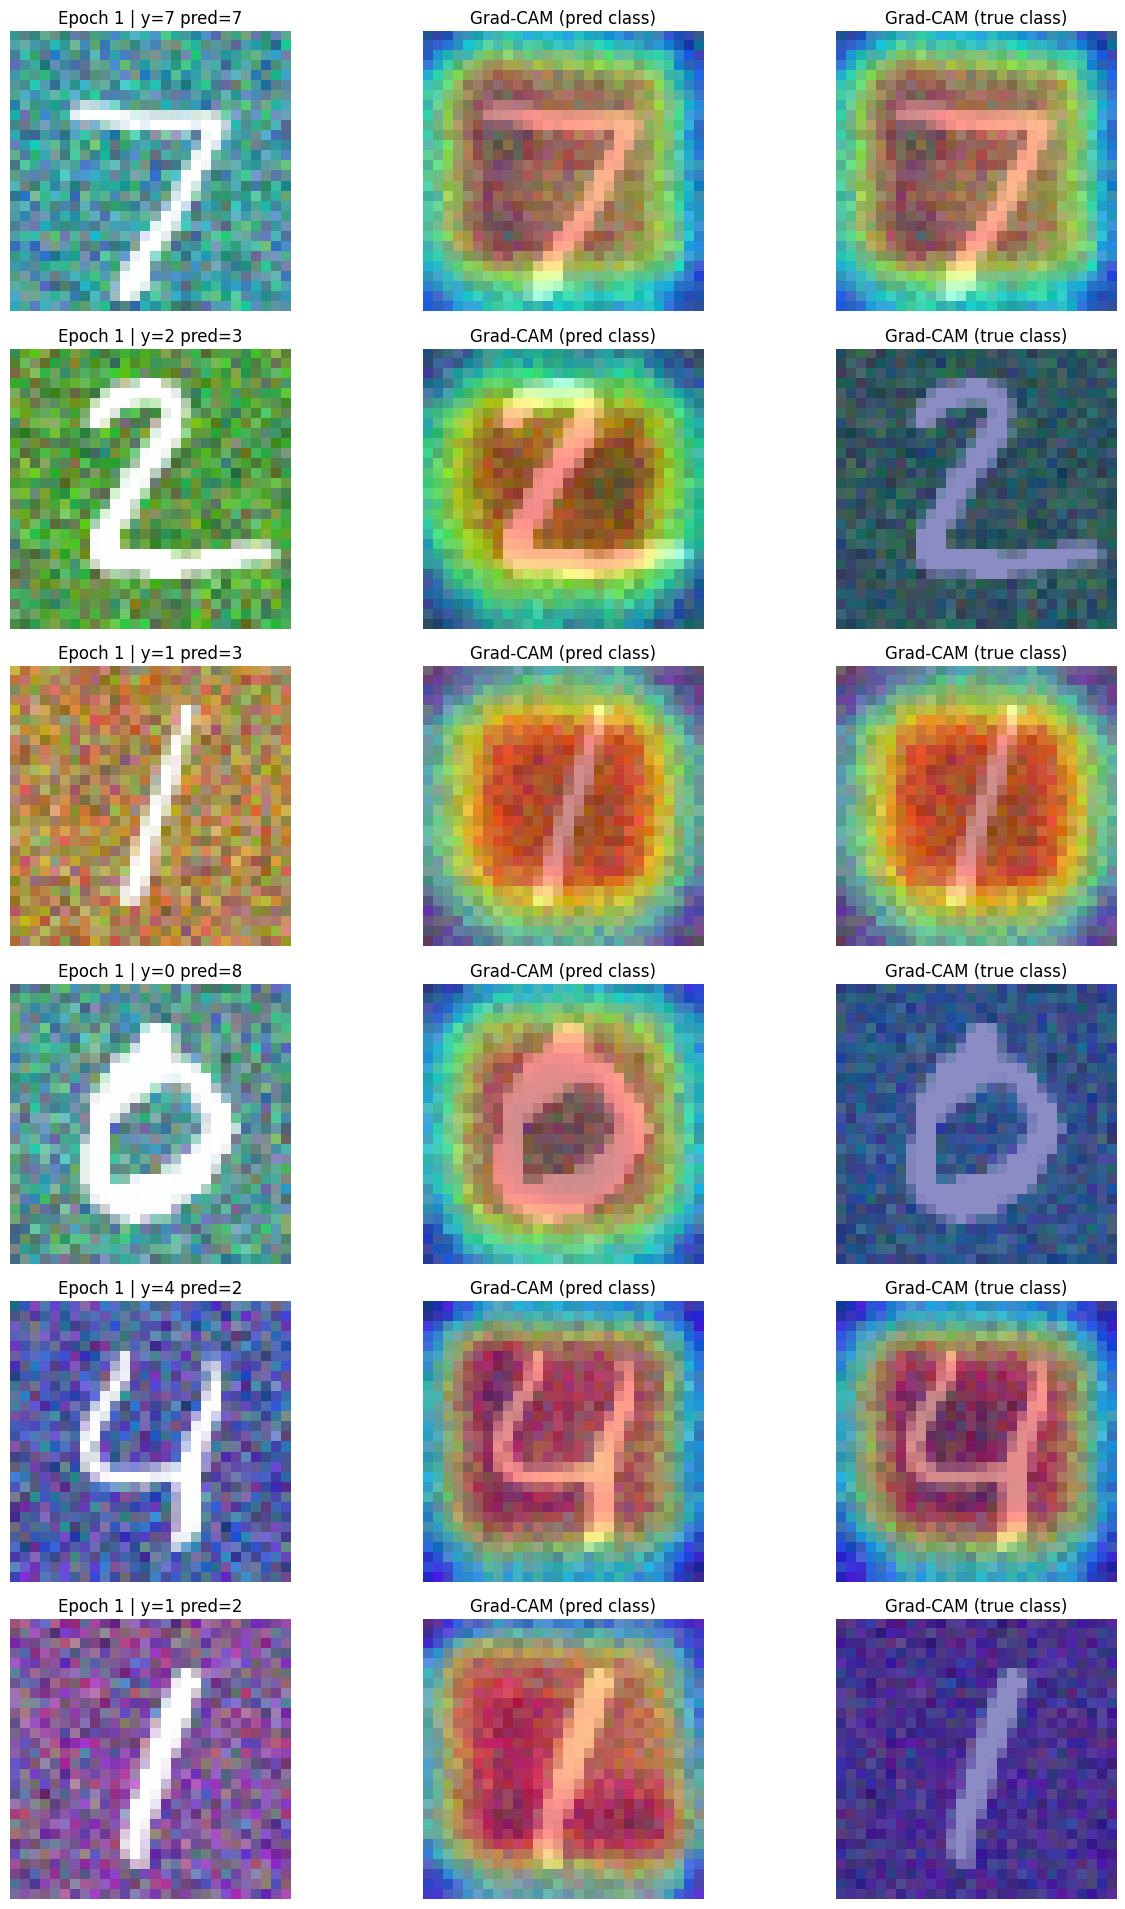

------------------------------
Epoch [2/6] - Loss: 1.2979 | lr=0.00500
Train Accuracy: 78.90%
Test Accuracy: 3.06%


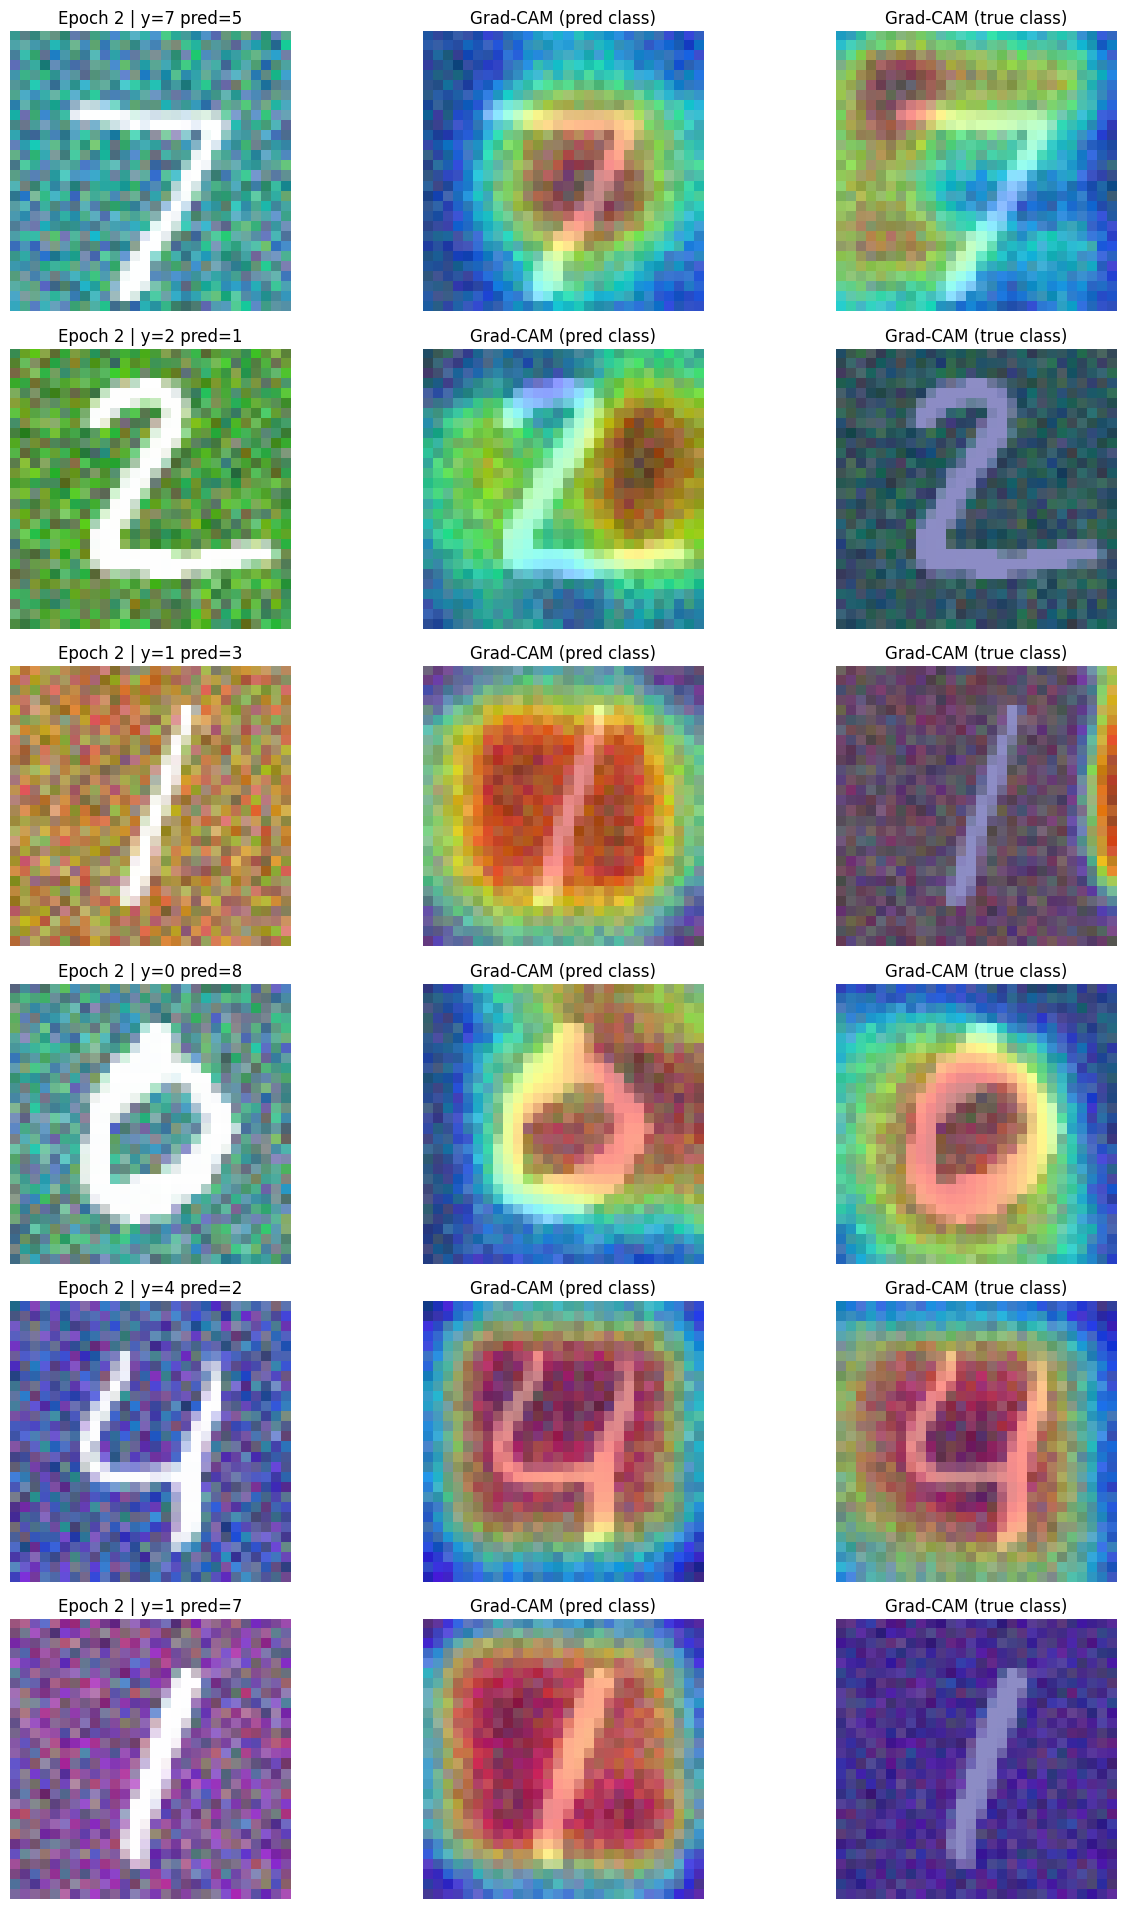

------------------------------
Epoch [3/6] - Loss: 0.5974 | lr=0.00500
Train Accuracy: 92.00%
Test Accuracy: 1.32%


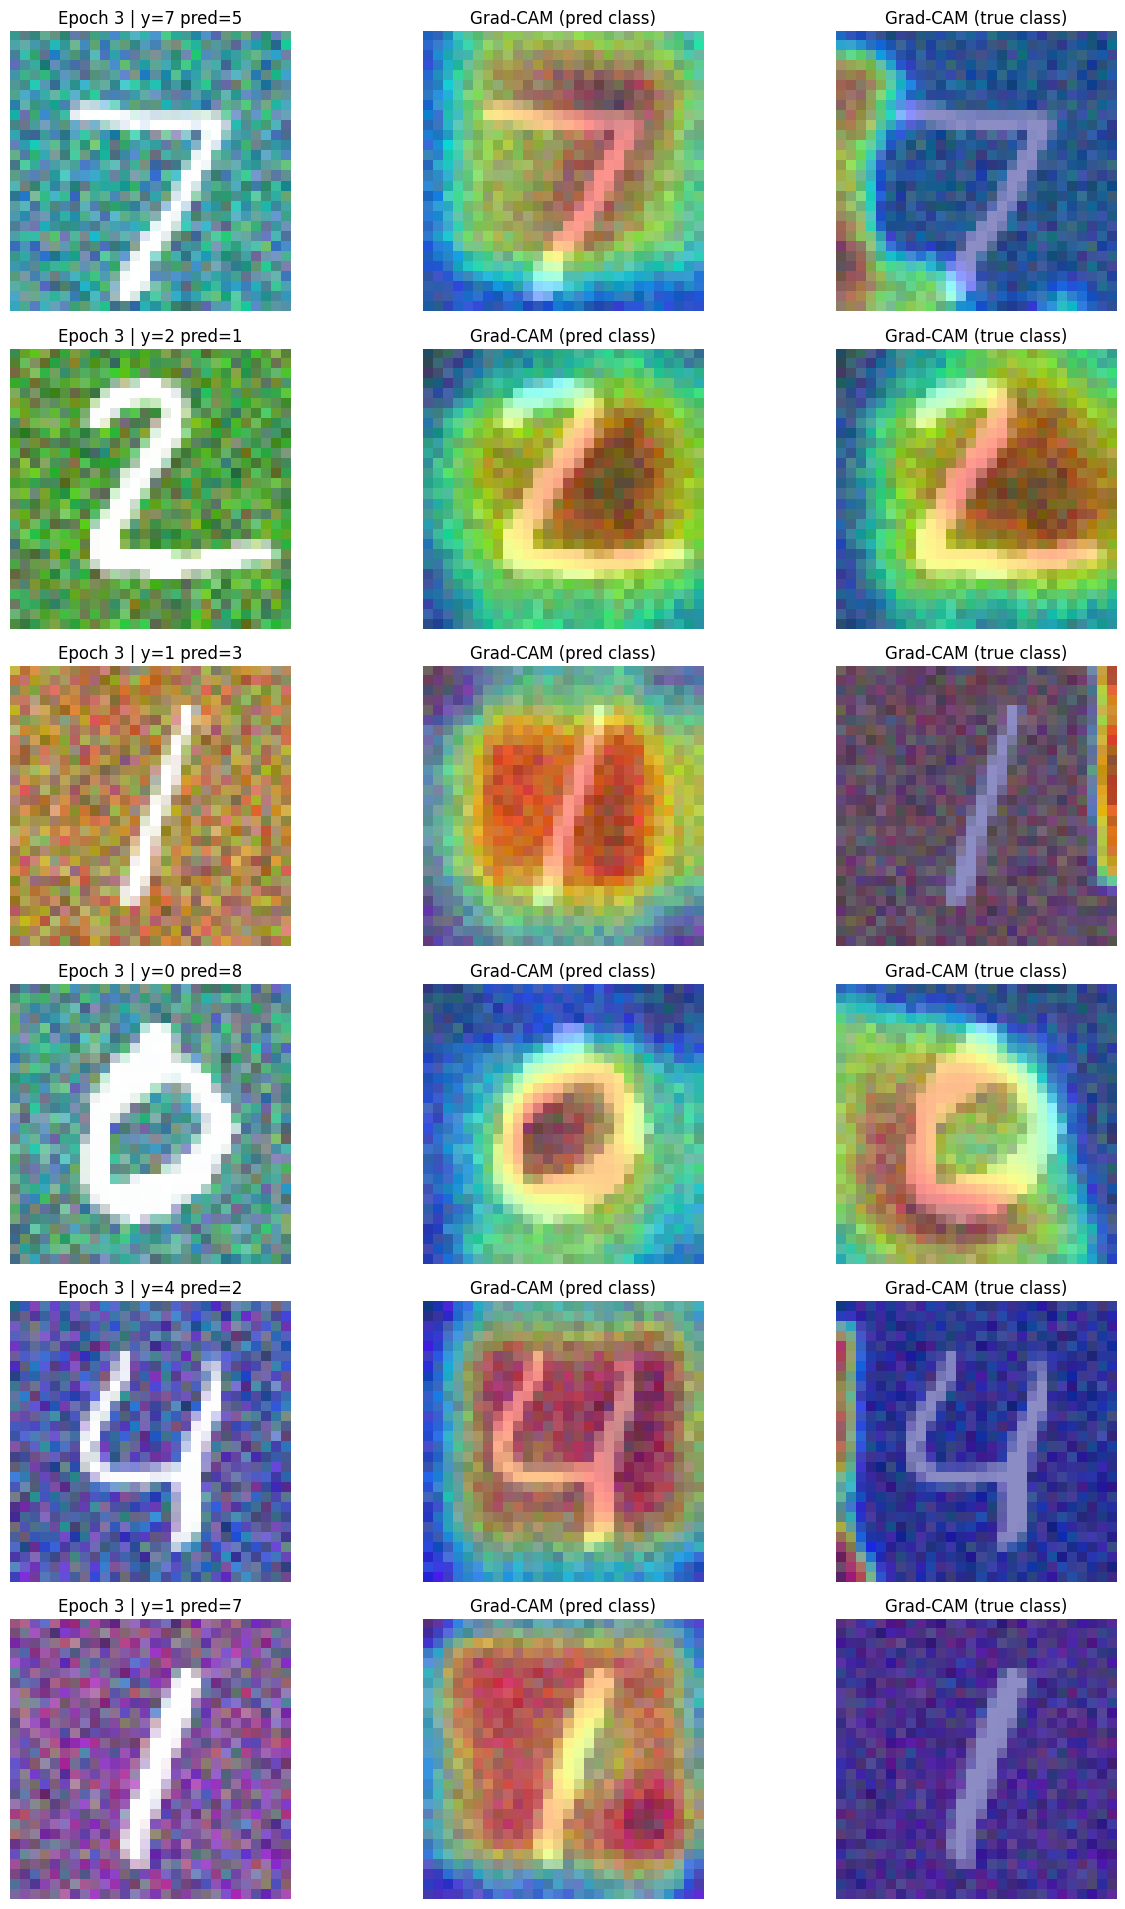

------------------------------
Epoch [4/6] - Loss: 0.3942 | lr=0.00500
Train Accuracy: 93.25%
Test Accuracy: 2.42%


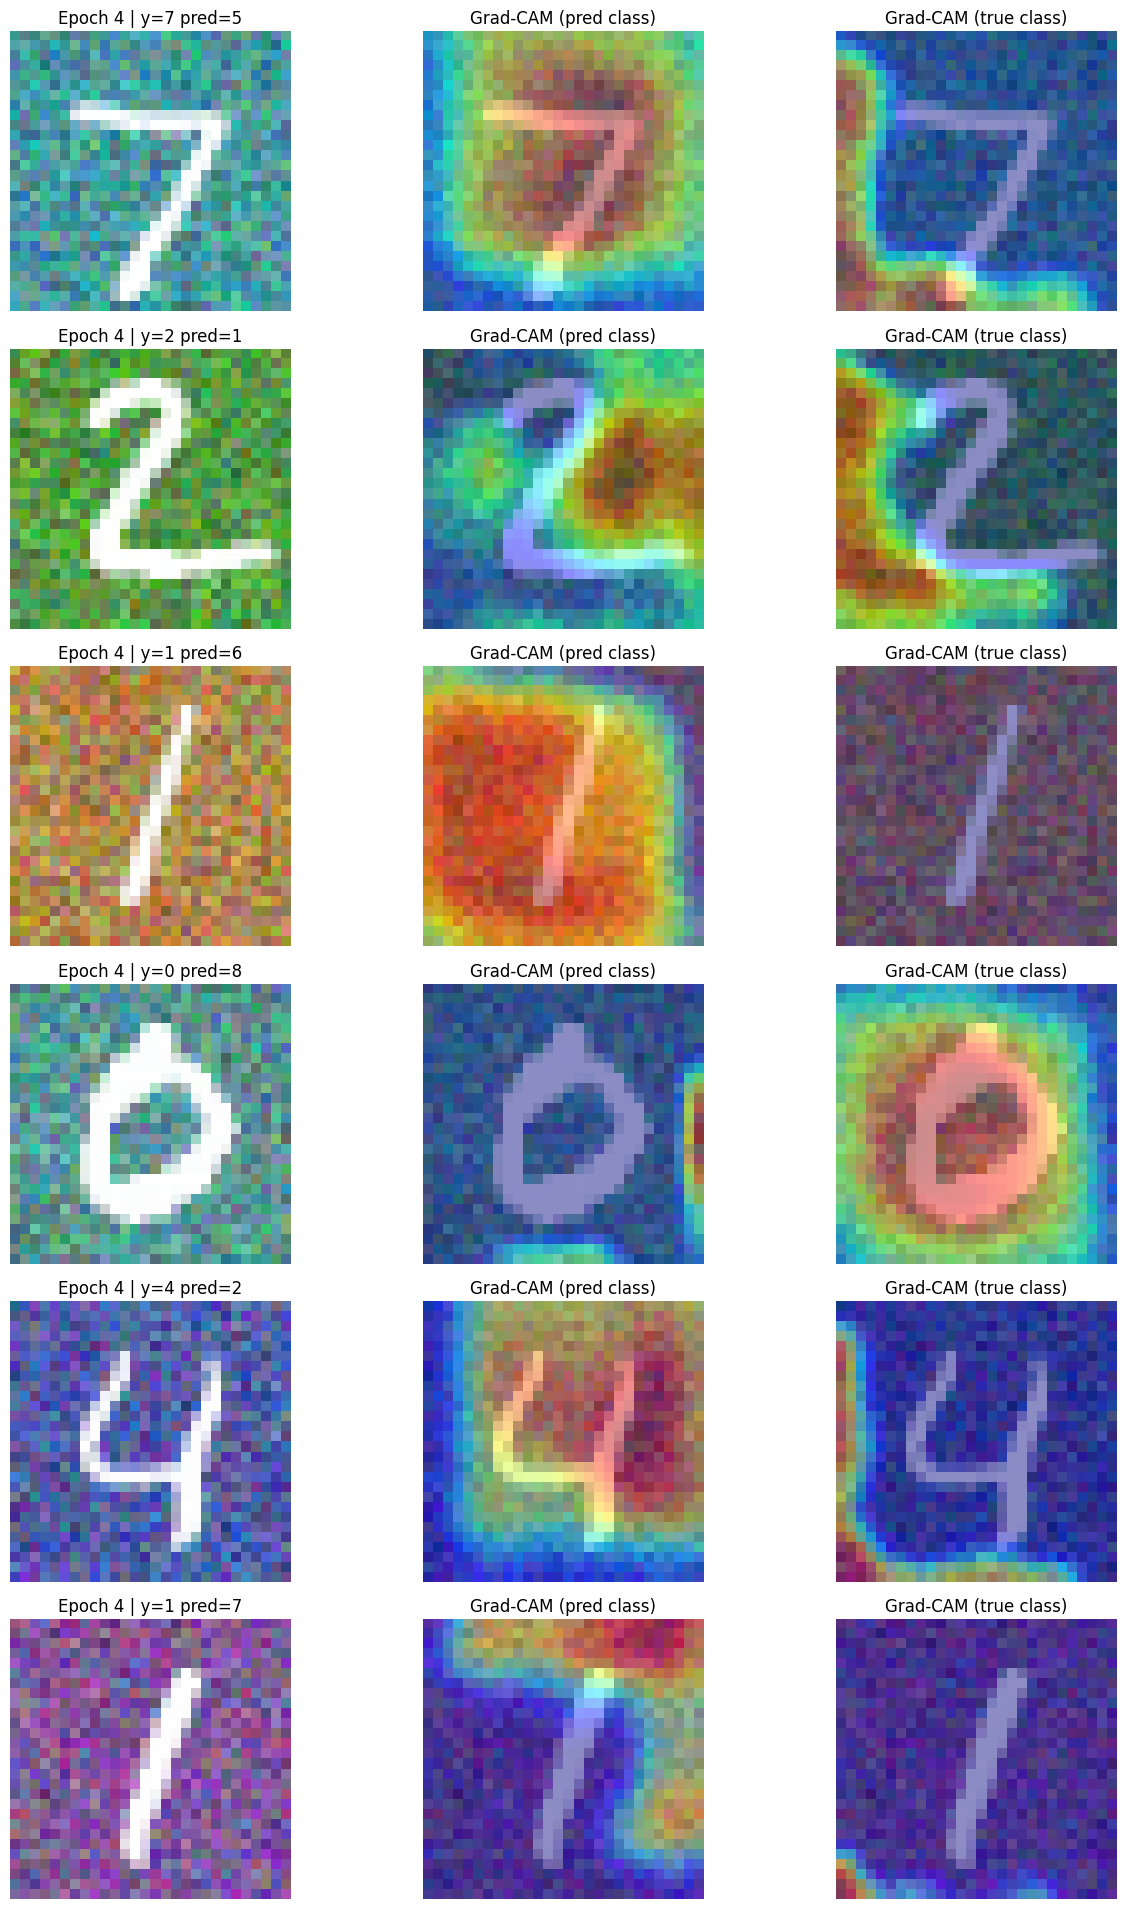

------------------------------
Epoch [5/6] - Loss: 0.3110 | lr=0.00500
Train Accuracy: 91.98%
Test Accuracy: 6.56%


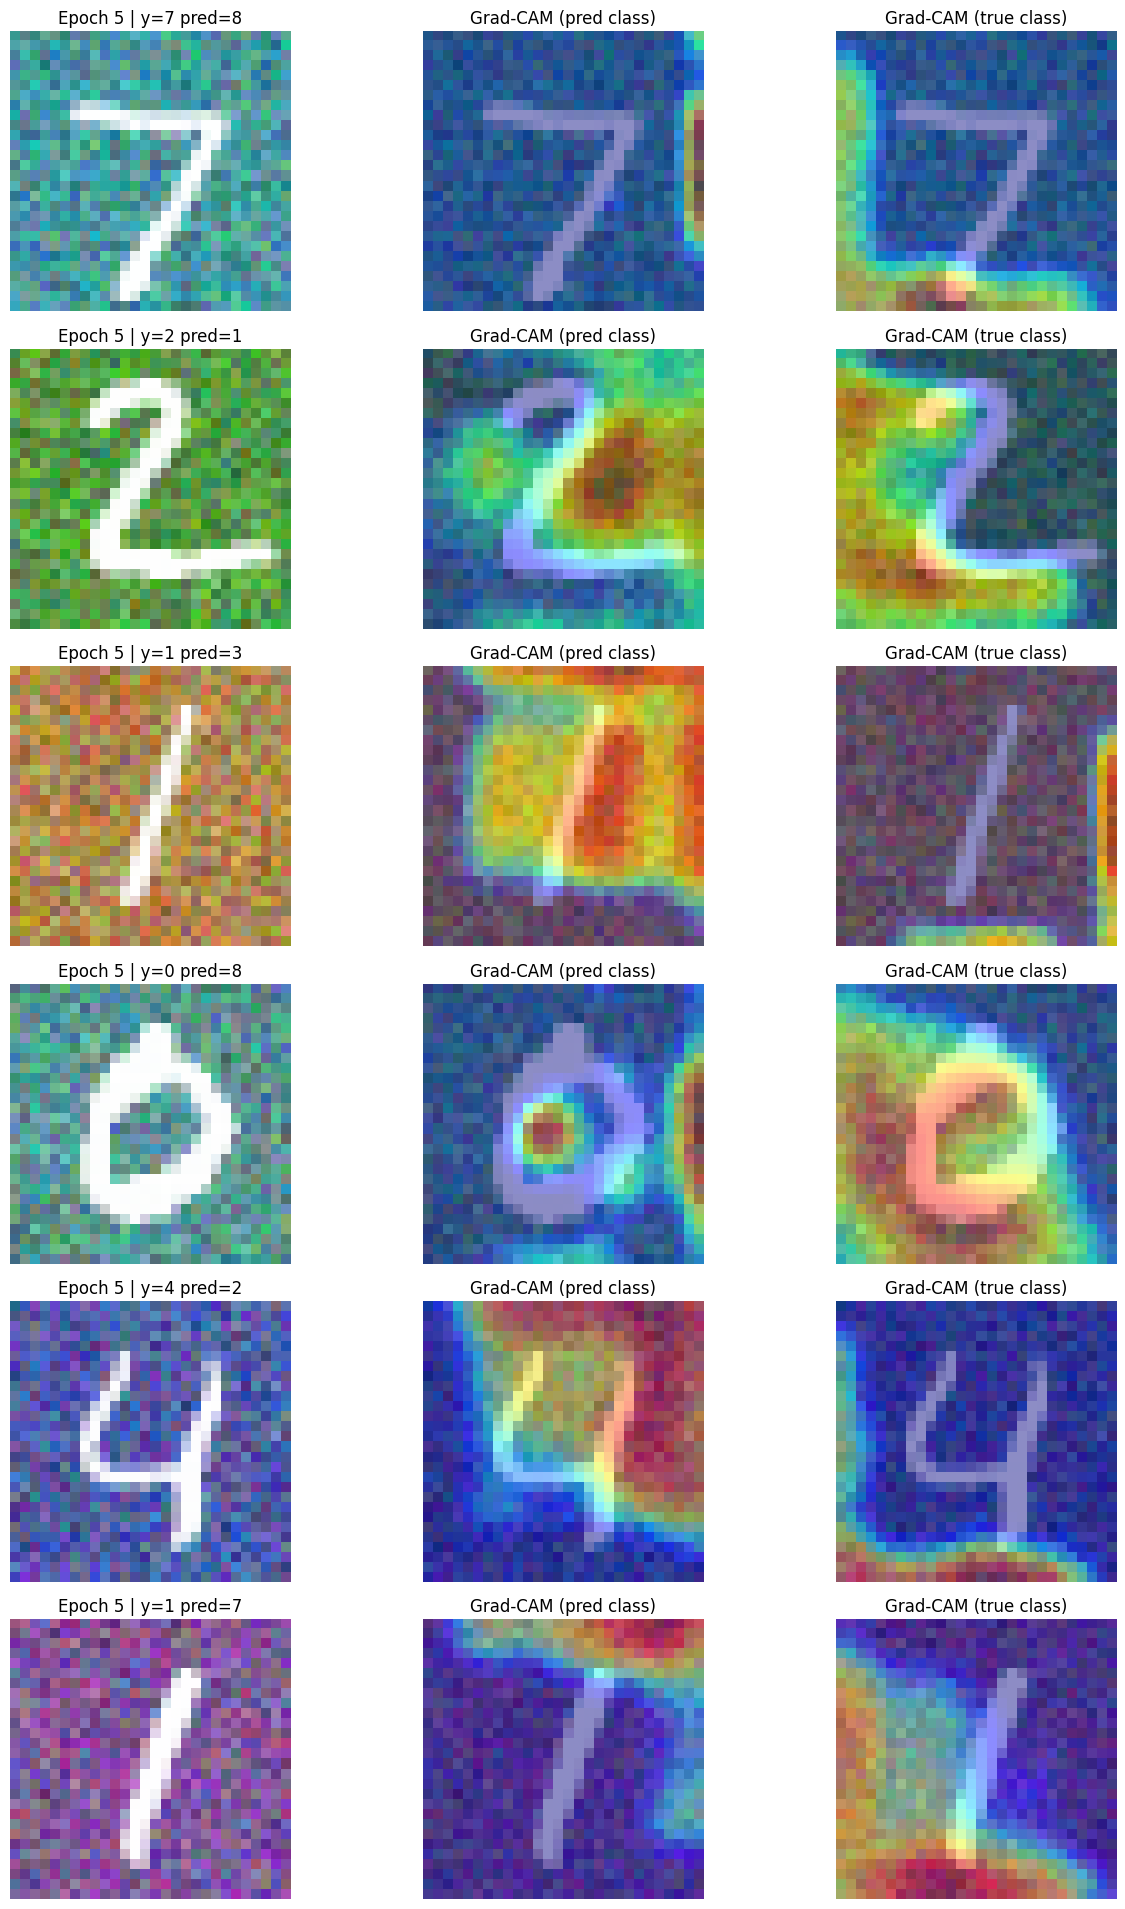

------------------------------
Epoch [6/6] - Loss: 0.2507 | lr=0.00500
Train Accuracy: 93.97%
Test Accuracy: 16.07%


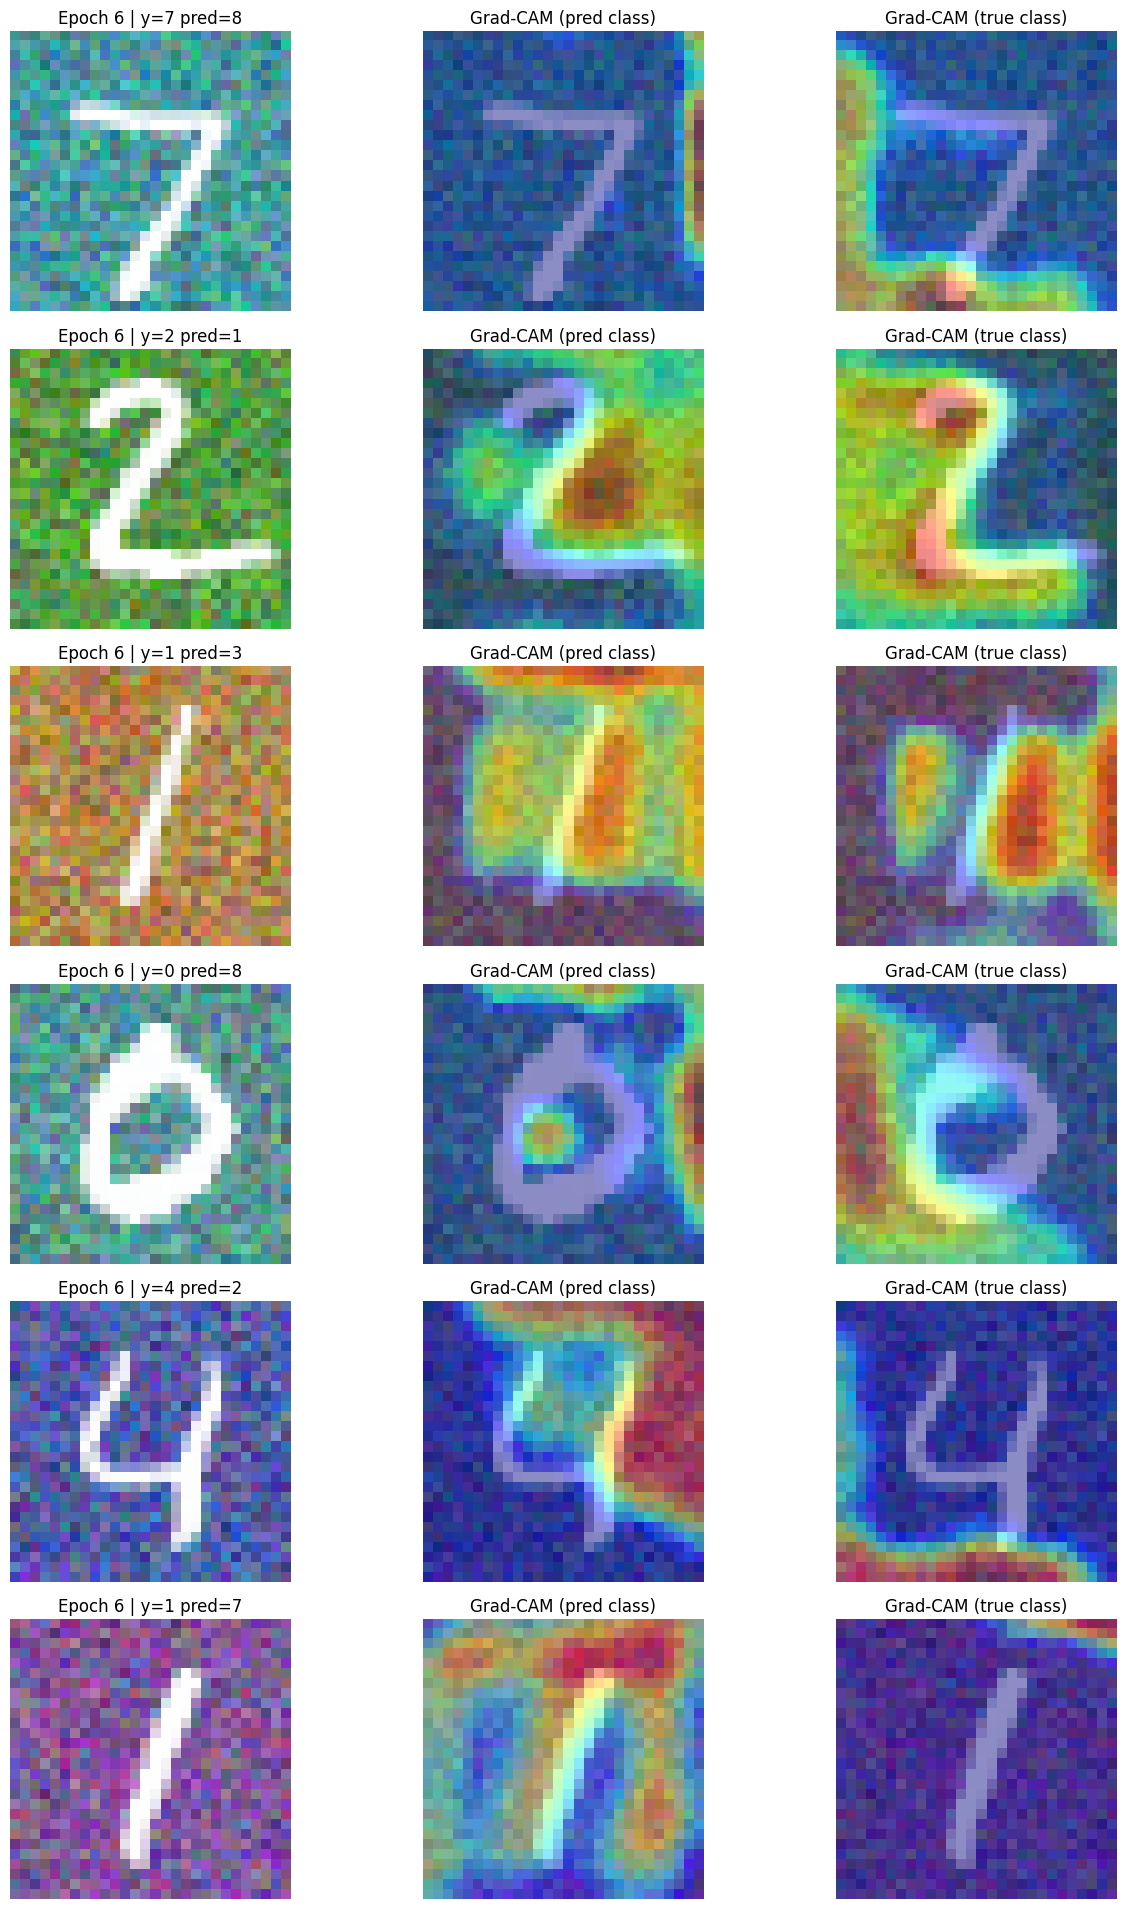

------------------------------
Training Complete.
Final Evaluation:
Train Accuracy: 93.97%
Test Accuracy: 16.07%


16.07

In [8]:
# Training hyperparams (SGD + momentum; works well for this size network)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    # weight_decay=1e-4,
)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

# scheduler = optim.lr_scheduler.MultiStepLR(
#     optimizer,
#     milestones=[9, 18, 24],
#     gamma=0.1,
# )

# Fixed images for epoch-by-epoch Grad-CAM comparisons (keep constant!)
_viz_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
viz_images, viz_labels = next(iter(_viz_loader))

# Target the last conv layer in this 2-conv network
gradcam = GradCAM(model, model.conv2)


def evaluate(loader, name):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:  # load one batch at a time
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc


def _gradcam_epoch_viz(epoch: int, max_items: int = 6):
    # Grad-CAM needs gradients; do NOT wrap this in torch.no_grad()
    model.eval()
    with torch.enable_grad():
        # CAM for predicted class
        cams_pred, logits = gradcam(viz_images.to(device))
        preds = logits.argmax(dim=1).detach().cpu()

        # CAM for true class (lets you compare "what would make the true label" vs what the model uses)
        cams_true, _ = gradcam(viz_images.to(device), class_idx=viz_labels.to(device))

    show_gradcam_overlays(
        viz_images,
        cams_pred.cpu(),
        cams_true.cpu(),
        viz_labels,
        preds,
        epoch=epoch,
        max_items=max_items,
    )


epochs = 6
print(f"Training for {epochs} epochs...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f} | lr={current_lr:.5f}")
    evaluate(train_loader, "Train")
    evaluate(test_loader, "Test")

    _gradcam_epoch_viz(epoch + 1, max_items=6)
    print("-" * 30)

print("Training Complete.")
print("Final Evaluation:")
evaluate(train_loader, "Train")
evaluate(test_loader, "Test")

# optional: if you re-run this cell multiple times, you can clean hooks with:
# gradcam.remove()


In [9]:
def save_model_weights(name: str, output_dir: str = "saved_models") -> str:
    """Save model weights to disk.

    Args:
        name: Filename stem or full filename (e.g., "cnn_v1" or "cnn_v1.pth").
        output_dir: Directory to save weights in.

    Returns:
        The full path to the saved weights file.
    """
    if not name:
        raise ValueError("name must be a non-empty string")

    filename = name if name.endswith(".pth") else f"{name}.pth"
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    full_path = output_path / filename
    torch.save(model.state_dict(), full_path)
    print(f"Saved weights to: {full_path}")
    return str(full_path)

# Example usage:
# save_model_weights("cnn_weights_v1")

#save_model_weights("cnn_weights_v1_27thJan")